In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [16]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model, Input

In [17]:
stockList = ["AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "IBM"]
start_date = "2010-01-01"
end_date = "2024-01-01"

In [ ]:
df_ = {}
for ticker in stockList:
    file_name = f"{ticker}_{start_date}_to_{end_date}.csv"
    df_[ticker] = pd.read_csv(file_name, index_col="Date", parse_dates=["Date"])

print(df_["AAPL"].head())

                Open      High       Low     Close     Volume
Date                                                         
2010-01-04  6.422875  6.455075  6.391277  6.440330  493729600
2010-01-05  6.458088  6.487880  6.417461  6.451467  601904800
2010-01-06  6.451465  6.477044  6.342225  6.348845  552160000
2010-01-07  6.372319  6.379842  6.291066  6.337109  477131200
2010-01-08  6.328683  6.379843  6.291368  6.379241  447610800


In [19]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2021", "Close")

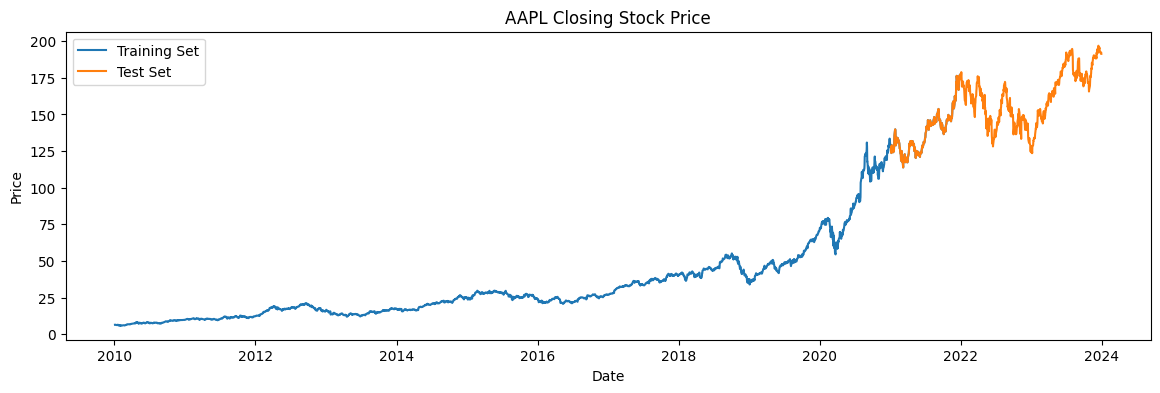

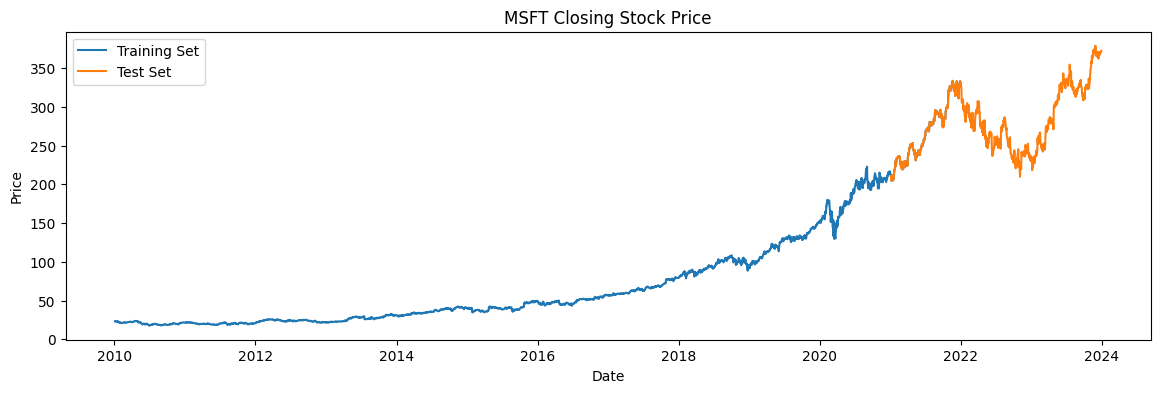

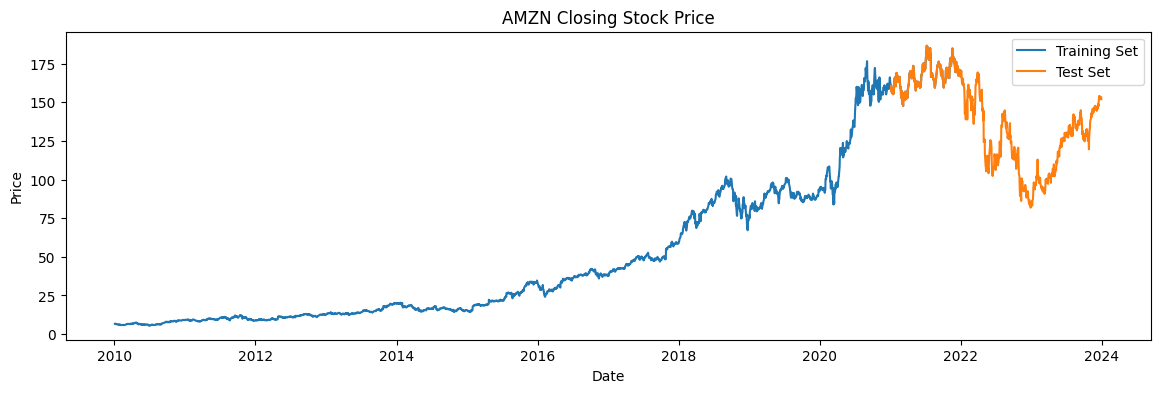

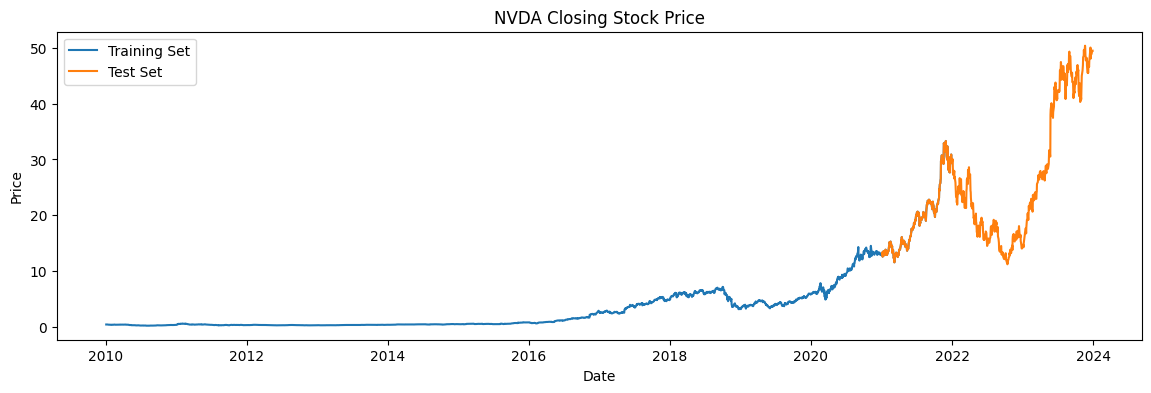

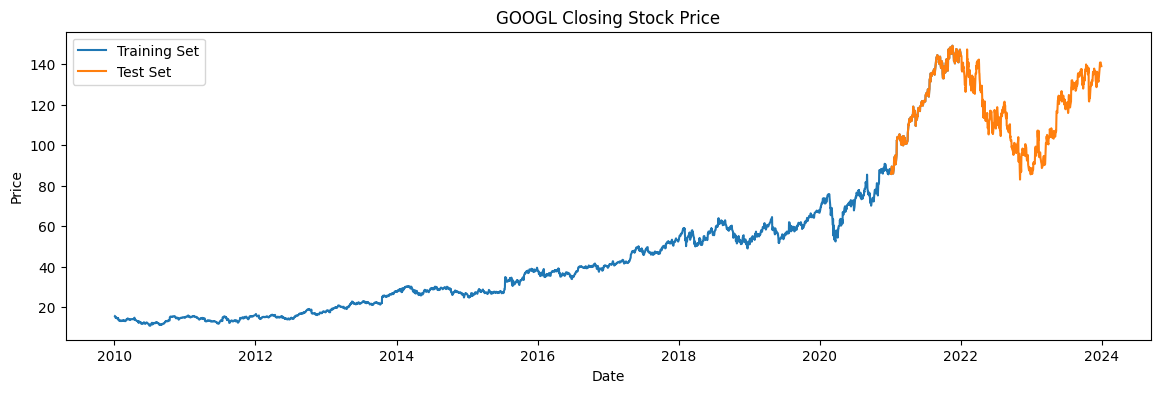

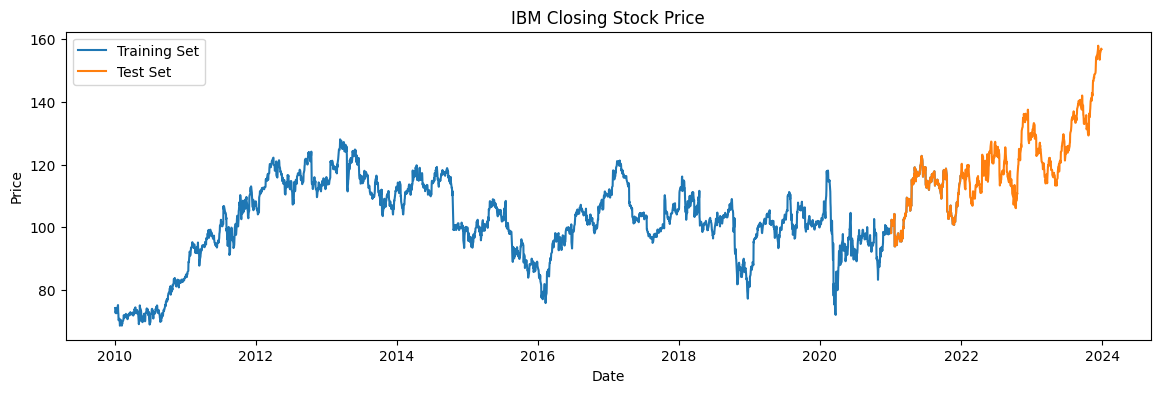

In [20]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [21]:
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [22]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

AAPL (3021, 1)
MSFT (3021, 1)
AMZN (3021, 1)
NVDA (3021, 1)
GOOGL (3021, 1)
IBM (3021, 1)


AAPL (753, 1)
MSFT (753, 1)
AMZN (753, 1)
NVDA (753, 1)
GOOGL (753, 1)
IBM (753, 1)


In [23]:
trainset = {}
testset = {}
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,3021):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 753):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [24]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
AAPL,"(2961, 60, 1)","(2961,)","(693, 60, 1)","(693,)"
MSFT,"(2961, 60, 1)","(2961,)","(693, 60, 1)","(693,)"
AMZN,"(2961, 60, 1)","(2961,)","(693, 60, 1)","(693,)"
NVDA,"(2961, 60, 1)","(2961,)","(693, 60, 1)","(693,)"
GOOGL,"(2961, 60, 1)","(2961,)","(693, 60, 1)","(693,)"
IBM,"(2961, 60, 1)","(2961,)","(693, 60, 1)","(693,)"


In [26]:
# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.get_positional_encoding(sequence_length, d_model)

    def get_positional_encoding(self, sequence_length, d_model):
        positions = np.arange(sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = np.zeros((sequence_length, d_model))
        pe[:, 0::2] = np.sin(positions * div_term)
        pe[:, 1::2] = np.cos(positions * div_term)
        return tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

In [27]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

In [28]:
# --- Build Transformer Model ---
def build_transformer_model(input_shape=(60, 1), num_heads=4, head_size=1, ff_dim=64, dropout=0.1, num_transformer_blocks=1):
    inputs = Input(shape=input_shape)

    # Add Positional Encoding
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)

    # Add multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

In [29]:
# Build a single shared transformer model
transformer_model = build_transformer_model(input_shape=(60, 1))

# Stack all stock training data together
X_all = np.concatenate([trainset[t]["X"] for t in stockList])
y_all = np.concatenate([trainset[t]["y"] for t in stockList])

# Train the transformer model once on the combined data
transformer_model.fit(X_all, y_all, epochs=50, batch_size=32)

Epoch 1/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0537
Epoch 2/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0030
Epoch 3/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0018
Epoch 4/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0015
Epoch 5/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0014
Epoch 6/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0013
Epoch 7/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012
Epoch 8/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012
Epoch 9/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011
Epoch 10/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0010
Epoch 11/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011
Epoch 12/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0010
Epoch 13/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.0839e-04
Epoch 14/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.4235e-04
Epoch 15/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


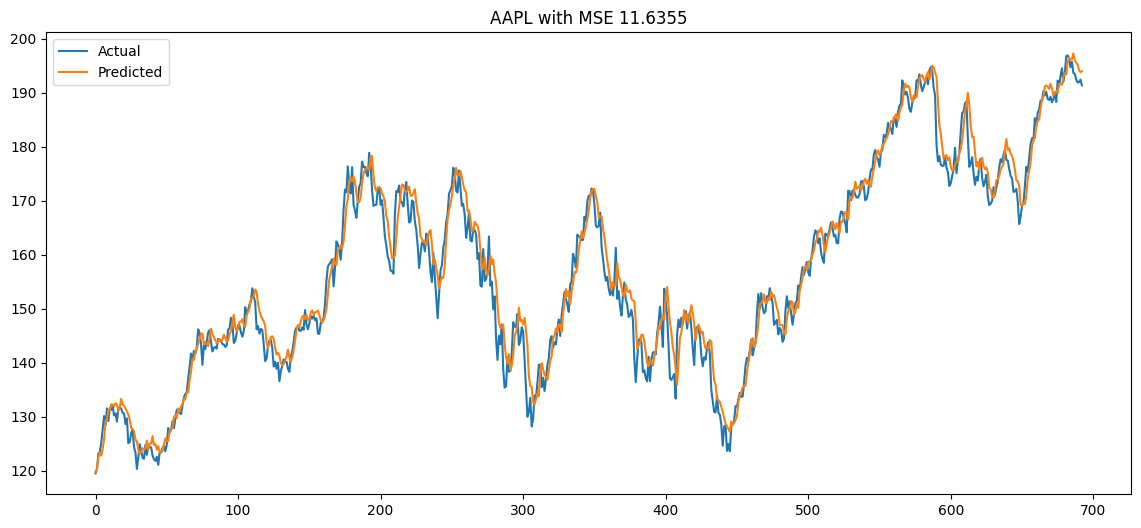

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


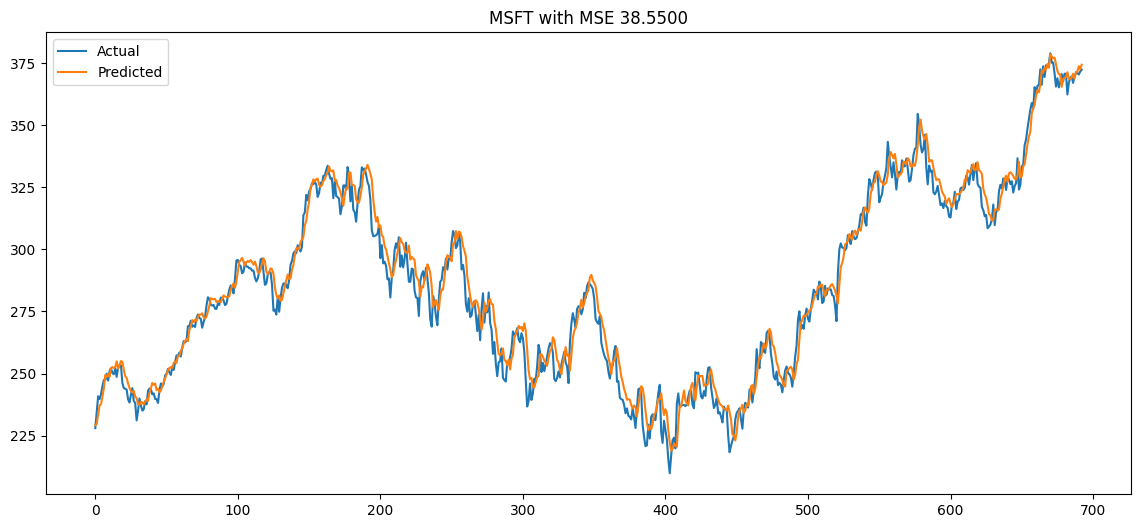

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


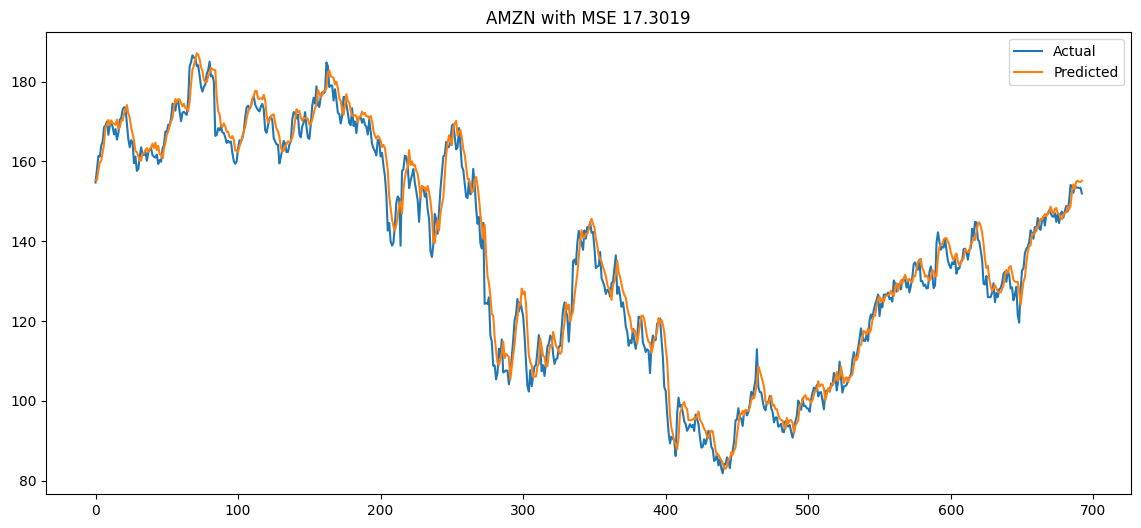

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


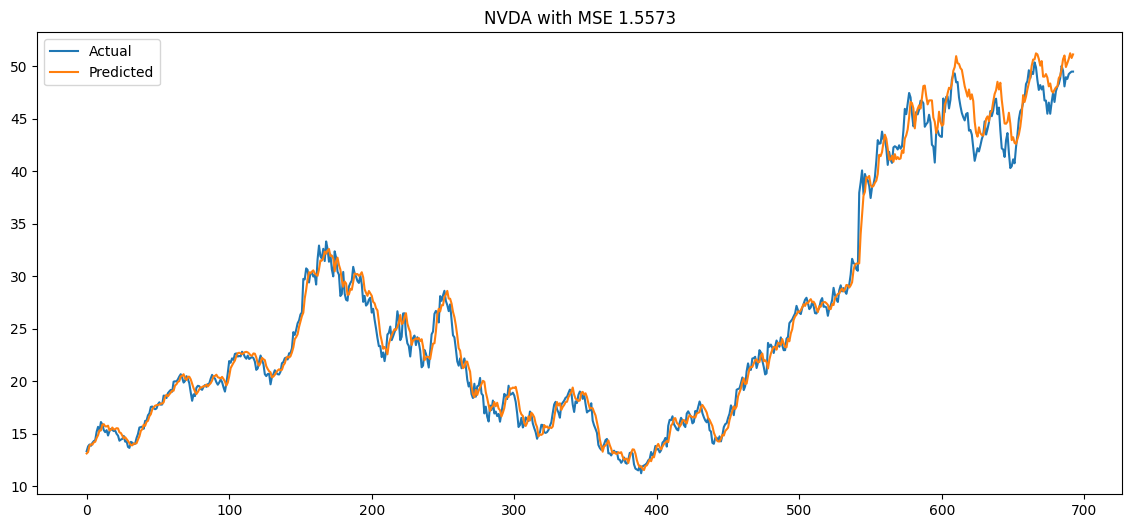

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


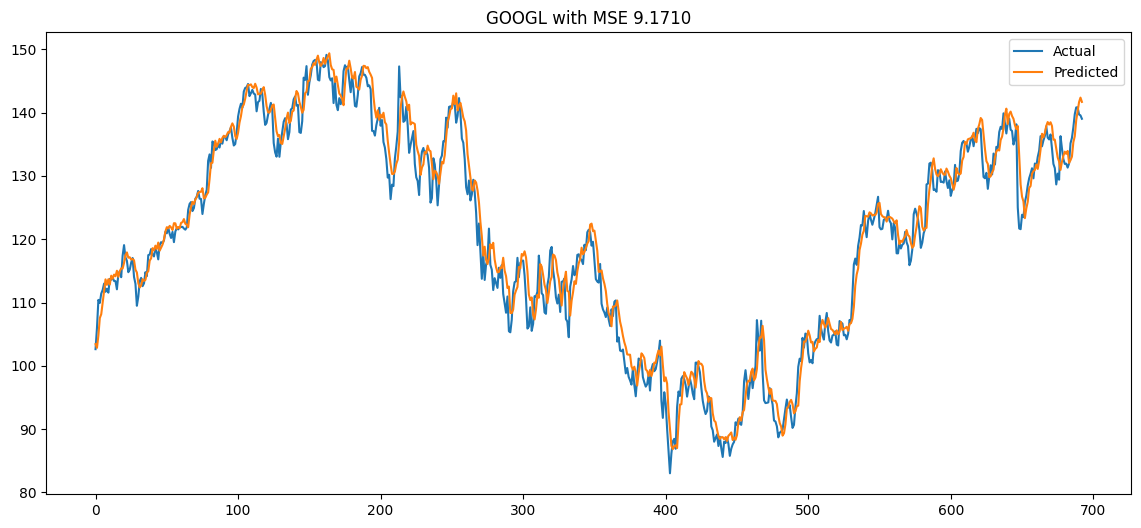

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


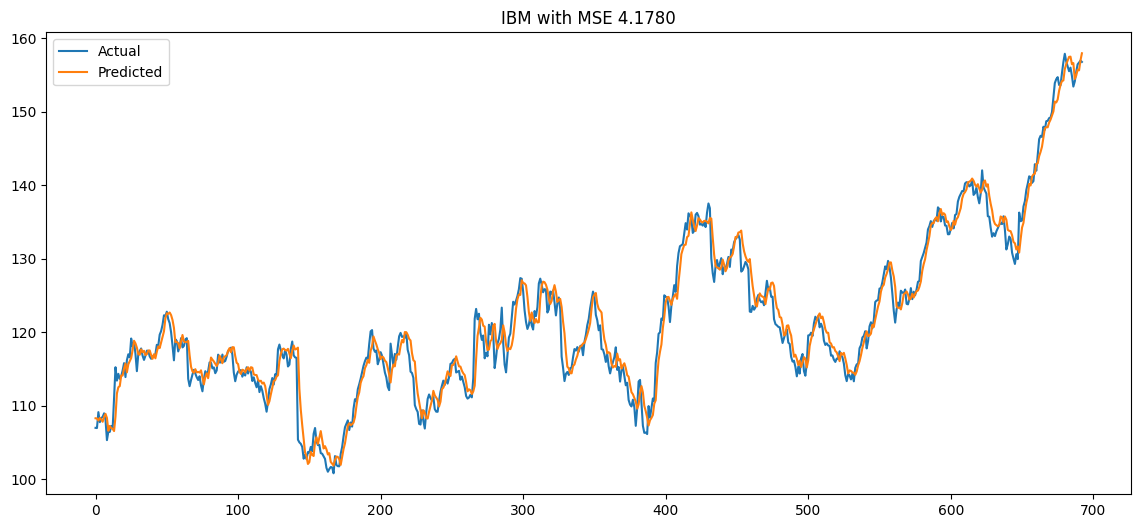

In [30]:
pred_result = {}
for ticker in stockList:
    y_true = scaler[ticker].inverse_transform(testset[ticker]["y"].reshape(-1,1))
    y_pred = scaler[ticker].inverse_transform(transformer_model.predict(testset[ticker]["X"]))
    mse = mean_squared_error(y_true, y_pred)

    pred_result[ticker] = {
        "True": y_true,
        "Pred": y_pred,
        "MSE": mse
    }

    # Plot results
    plt.figure(figsize=(14,6))
    plt.title(f"{ticker} with MSE {mse:.4f}")
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.legend()
    plt.show()

In [31]:
transformer_model.save("caleb_transformer.h5")